## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [6]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [7]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [8]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [9]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [10]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [11]:
target = 'survived'

In [14]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O']
vars_cat = [var for var in data.columns if data[var].dtypes == 'O']

In [15]:
print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [18]:
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

In [26]:
vars_num_with_na = [var for var in vars_num if var in vars_with_na]

In [33]:
data[vars_num_with_na].isna().mean()

age     0.200917
fare    0.000764
dtype: float64

In [29]:
# now in categorical variables
vars_cat_with_na = [var for var in vars_cat if var in vars_with_na]

In [34]:
data[vars_cat_with_na].isna().mean()

cabin       0.774637
embarked    0.001528
dtype: float64

#### Analyse relationship between missing values and the mean of the target (survived)

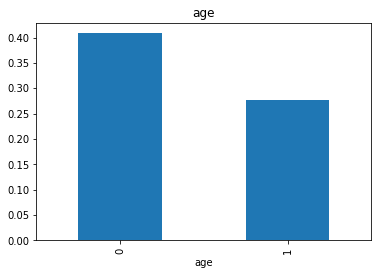

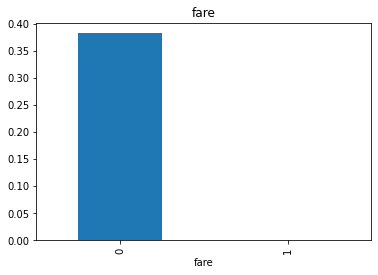

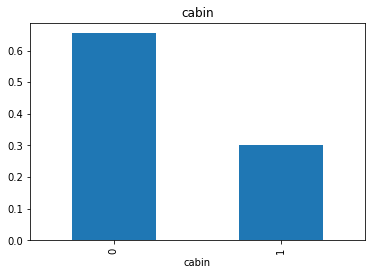

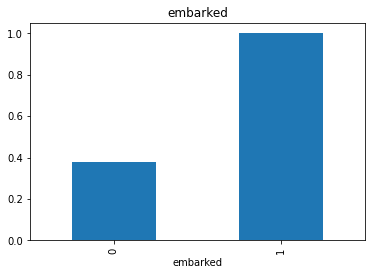

In [47]:
def analyse_na_value(df, var):

    df = df.copy()

    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median SalePrice in the observations where data is missing
    # vs the observations where a value is available

    df.groupby(var)['survived'].mean().plot.bar()

    plt.title(var)
    plt.show()


# let's run the function on each variable with missing data
for var in vars_with_na:
    analyse_na_value(data, var)

### Determine cardinality of categorical variables

In [36]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

In [40]:
vars_disc = [var for var in vars_num if data[var].dtypes == int]

In [45]:
vars_cont = [var for var in vars_num if data[var].dtypes != int]

In [41]:
vars_disc

['pclass', 'survived', 'sibsp', 'parch']

In [43]:
# these variables can be treated as categorical
data[vars_disc].nunique()

pclass      3
survived    2
sibsp       7
parch       8
dtype: int64

### Determine the distribution of numerical variables

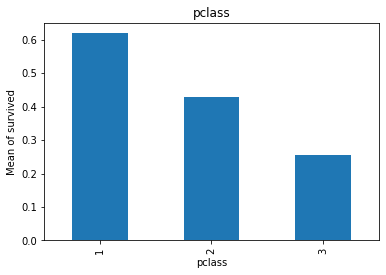

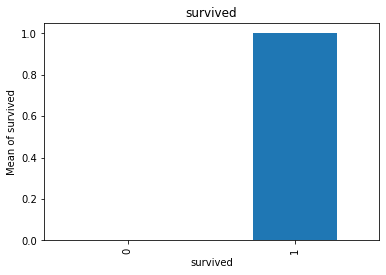

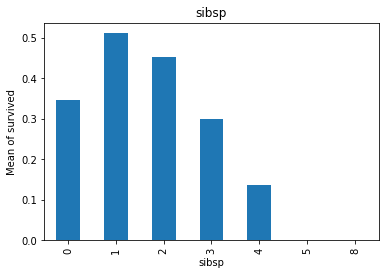

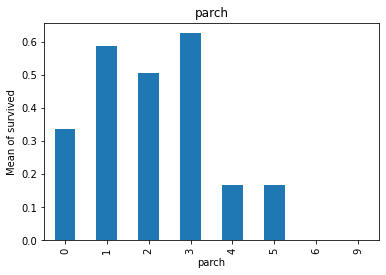

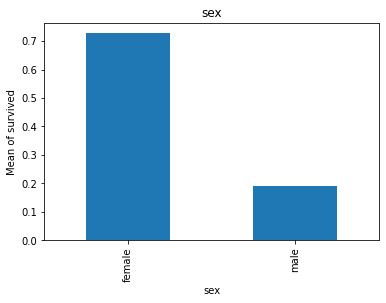

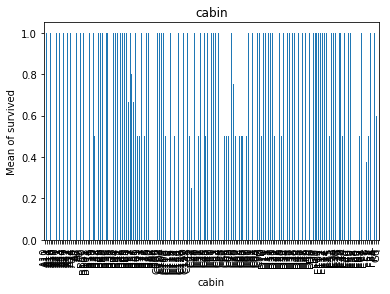

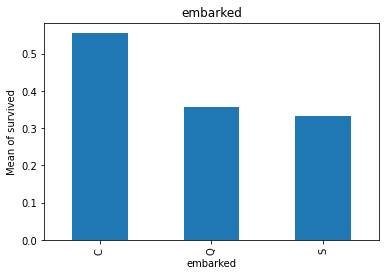

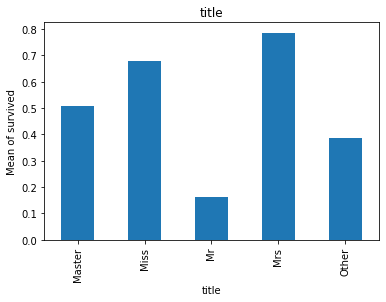

In [49]:
def analyse_discrete_w_target(df, var):
    df = df.copy()
    df.groupby(var)['survived'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('Mean of survived')
    plt.show()
    
for var in vars_disc + vars_cat:
    analyse_discrete_w_target(data, var)

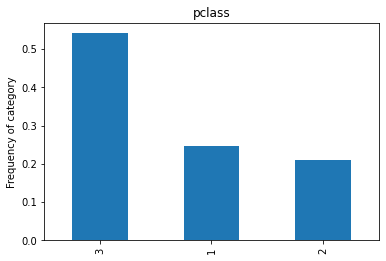

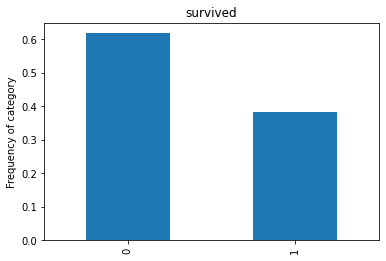

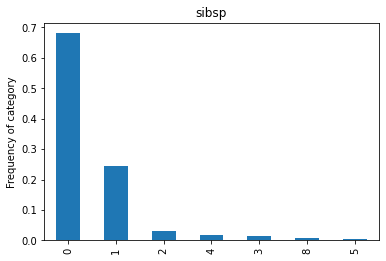

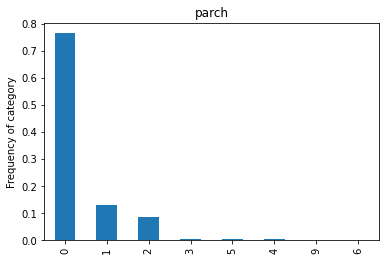

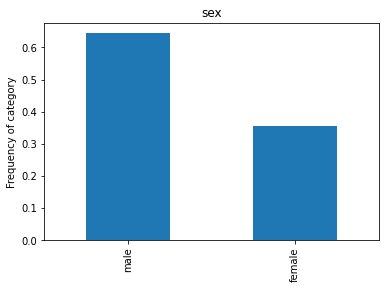

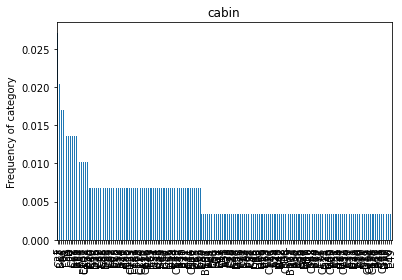

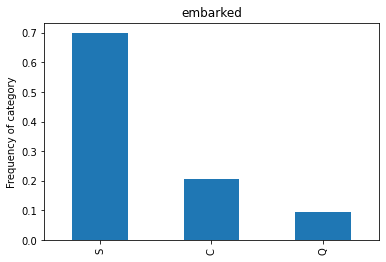

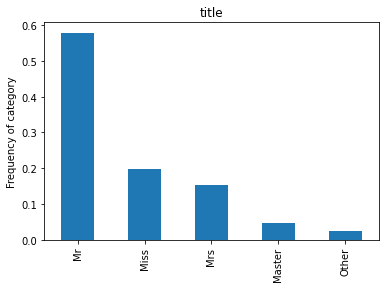

In [66]:
def analyse_discrete(df, var):
    df = df.copy()
    df[var].value_counts(normalize=True).plot.bar()
    plt.title(var)
    plt.ylabel('Frequency of category')
    plt.show()
    
for var in vars_disc + vars_cat:
    analyse_discrete(data, var)

#### Analyse continuous data

In [ ]:
from scipy.stats import normaltest

In [72]:
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins = 30)
    
    stat, p = normaltest(data[var])
    alpha = 0.05

    if p > alpha:
        plt.title(var+' : Gaussian')
    else:
        plt.title(var+' : Non Gaussian')
    plt.ylabel('pdf')
    plt.xlabel(var)
    plt.show()

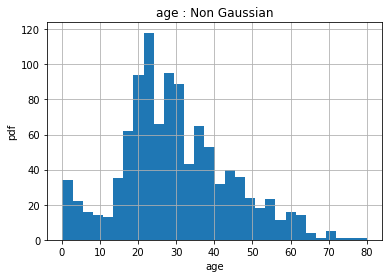

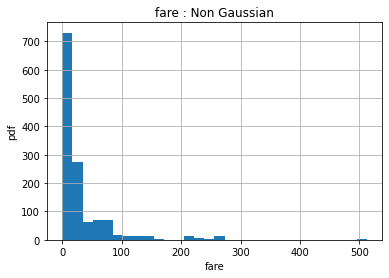

In [74]:
for var in vars_cont:
    analyse_continuous(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [132]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [133]:
X_train['cabin'] = X_train['cabin'].str.slice(0,1)
X_test['cabin'] = X_test['cabin'].str.slice(0,1)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [134]:
for var in vars_num_with_na:
    median_val = X_train[var].median()
    
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)
    
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

In [135]:
X_train[vars_num_with_na].isnull().sum()

age     0
fare    0
dtype: int64

In [136]:
X_test[vars_num_with_na].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [137]:
for var in vars_cat_with_na:
    X_train[var].fillna('Missing', inplace=True)
    X_test[var].fillna('Missing', inplace=True)

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [138]:
def find_frequent_labels(df, var, rare_perc):
    df = df.copy()
    
    tmp = df[var].value_counts(normalize=True)
    
    return tmp[tmp > rare_perc].index

In [139]:
for var in vars_cat:
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    X_train[var] = \
        np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = \
        np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [140]:
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

In [141]:
ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    variables=vars_cat,
    drop_last=True)

In [142]:
ohe_enc.fit(X_train)

OneHotCategoricalEncoder(drop_last=True,
                         variables=['sex', 'cabin', 'embarked', 'title'])

In [143]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

### Scale the variables

- Use the standard scaler from Scikit-learn

In [144]:
from sklearn.preprocessing import StandardScaler

In [145]:
scaler = StandardScaler()

In [152]:
X_columns = X_train.columns

In [153]:
scaler.fit(X_train)

StandardScaler()

In [154]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [156]:
X_train = pd.DataFrame(X_train, columns = X_columns)
X_test = pd.DataFrame(X_test, columns = X_columns)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [158]:
from sklearn.linear_model import LogisticRegression

In [161]:
model = LogisticRegression(C=1/0.0005, random_state=0)

In [162]:
model.fit(X_train, y_train)

LogisticRegression(C=2000.0, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [164]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [170]:
y_train_proba = model.predict_proba(X_train)[:,1]
y_train_pred = model.predict(X_train)

In [168]:
y_test_proba = model.predict_proba(X_test)[:,1]
y_test_pred = model.predict(X_test)

In [174]:
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.8137535816618912, 0.7938931297709924)

In [175]:
roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)

(0.8580390262751159, 0.8568827160493827)

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**